# A clustering approach for damage detection

This work presents a clustering approach for damage detection and joints classification on bridges.

The motivation of this work is to:

   1. identify clusters of bridge parts with similar behaviors based on sensor data and other information
   2. understand bridge global behavior
   3. complement local damage identification techniques


In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# some generic imports we need
from pandas import DataFrame, read_csv
import pylab as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from datetime import datetime
from scipy.fftpack import fft
import scipy.signal.signaltools as sigtool
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split

# load our own methods
%run outliers_removal.py
%run data_processing.py
%run kmeans.py
%run map_pairwise_distances.py
path = '/media/alberto/9AE6A9E8E6A9C53B/Users/104166/Data/TIFER/work_tracking/SHM/python_code/'

## Data set 2:

- 71 joints were monitored from the 1st of October to the 7th of October 2014. 
- It is known that one joint (72) was recently repaired and sensor in joint 135 is faulty
- Each event containing 100 samples before the event was triggered, and 500 samples were collected during and after the event has occurred. 
- Joints monitored belong to the following bridge zones: span 6, span 7, span 8, North pylon and North main span.

In [4]:
# loading dataset
datav1 = read_csv(path+"data_v1_118nodes_oct.csv")
joints = read_csv(path+"joints_118nodes_oct.csv")
joints = joints[~np.isnan(datav1).any(axis=1)]
datav1 = datav1[~np.isnan(datav1).any(axis=1)]
print ('Data size: ' + str(datav1.shape))

Data size: (45818, 500)


## A first look at the dataset

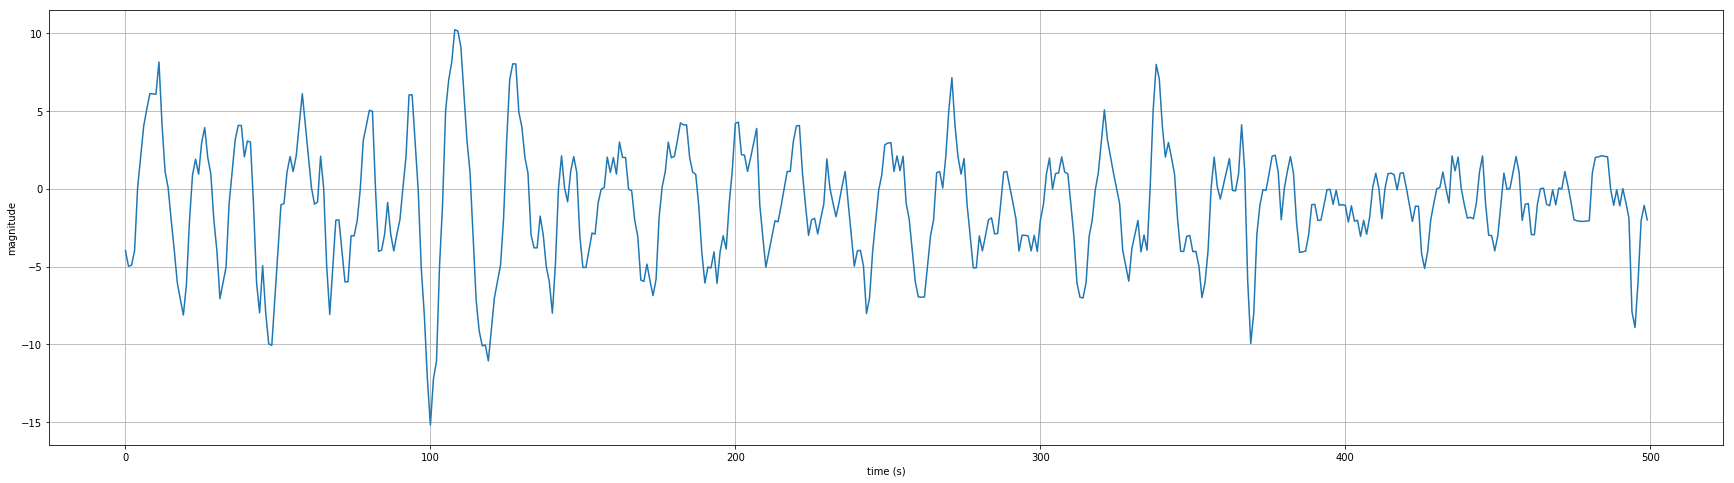

In [29]:
# show a feature vector, raw data
plt.figure(figsize=(30,8))
plt.plot(datav1.values[100])
plt.xlabel('time (s)')
plt.ylabel('magnitude')
plt.grid()
plt.show()

## Data preprocessing

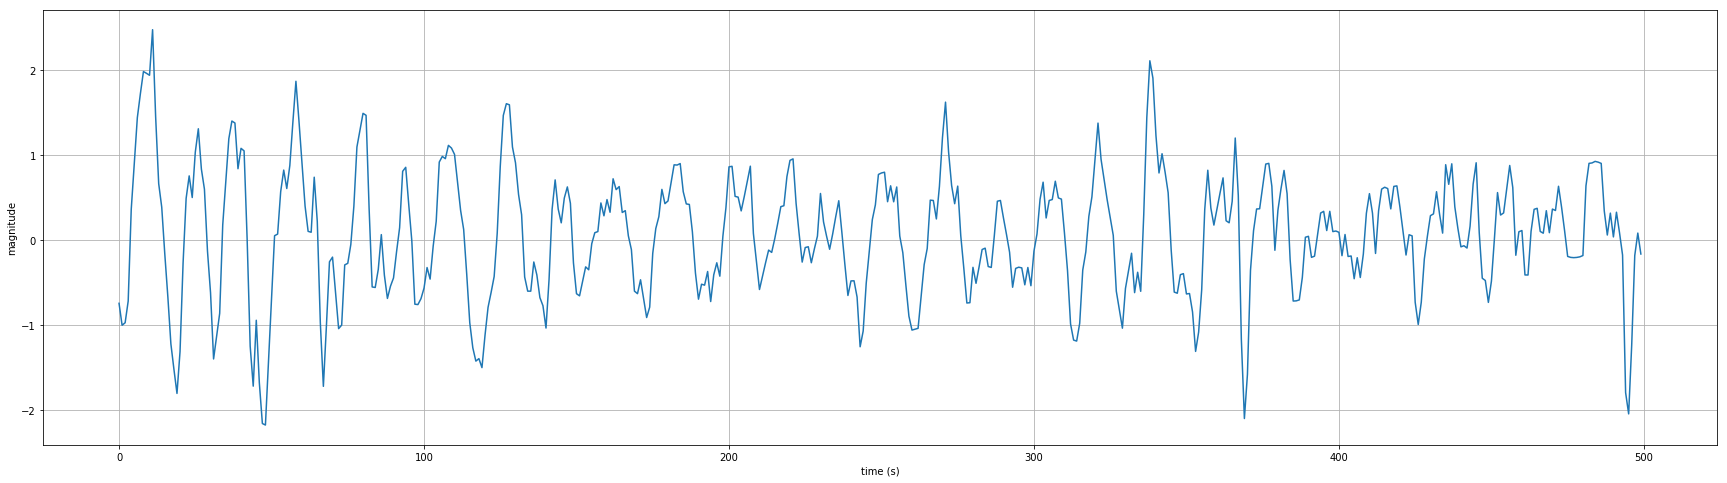

In [30]:
# scale dataset
from numpy import mean, std
datav1 = (datav1.values - mean(datav1.values, axis=0)) / std(datav1.values, axis=0)

# show a feature vector, scaled data
plt.figure(figsize=(30,8))
plt.plot(datav1[100])
plt.xlabel('time (s)')
plt.ylabel('magnitude')
plt.grid()
plt.show() 

## Contextual information: joints positions and distribution

In [31]:
joints=np.array(joints)
joints=joints.reshape(joints.shape[0])
joints_dist = [[17,24,25,26,21,22],[13,20,16,14,15,11],[18,12,19,27,28,29],[30,31,33,34,35],[37,39,41],[42,43,45,47],[143,142,141,140,139,138],[136,135,134,133,131],[129,128,126,125],[123,121],[111,110,109,107],[177,175],[174,173,172,169],[165,164],[162,161,160,159],[82],[78,77,75,74,73,72],[99]]


## Remove outliers from data

In [32]:
'''
Outliers removal method for data cleaning and resampling, which for each joint eliminates those events that are far from the mean of the energy of the joint's events.
    Inputs:
        - data: training data set containing the events to be processed (matrix [m,n])
        - index: the list of events' labels (joints), (array [m])
        - k: number of neighbours to be considered by the KDTree and maximum number of resulting events per label
        - normalityLoops: stopping criteria
        - anomaly_threshold: std from the mean to be used
    Outputs: (reduced_data, reduced_index, samples_distribution) objects containing the cleaned data, the corresponding labels and the final label distribution 
'''
# the number of neighbors, 'k', is set depending on the amount of data per joint
# 'normalityLoops' is set to 1 to not removing much information
reduced_data, reduced_index, samples_distribution, removed_data, removed_index = outliers_removal(datav1, 
                                                                                                  joints, 
                                                                                                  k=500, 
                                                                                                  normalityLoops=1)
# show resulting number of features
print ('Reduced data size: ' + str(reduced_data.shape))



Joint 11
Iteration 1
462
Average distance: 108.311060
Max distance: 843.135278
Setting threshold to  nan
Number of samples removed: 19
Number of iterations reached. Exiting

Joint 12
Iteration 1
500
Average distance: 28.640000
Max distance: 58.963279
Setting threshold to  nan
Number of samples removed: 1088
Number of iterations reached. Exiting

Joint 13
Iteration 1
500
Average distance: 122.470833
Max distance: 341.238265
Setting threshold to  nan
Number of samples removed: 39
Number of iterations reached. Exiting

Joint 14
Iteration 1
500
Average distance: 183.757606
Max distance: 465.508932
Setting threshold to  nan
Number of samples removed: 49
Number of iterations reached. Exiting

Joint 15
Iteration 1
500
Average distance: 118.706760
Max distance: 347.365685
Setting threshold to  nan
Number of samples removed: 39
Number of iterations reached. Exiting

Joint 16
Iteration 1
500
Average distance: 214.885211
Max distance: 578.125358
Setting threshold to  nan
Number of samples remove


Joint 133
Iteration 1
500
Average distance: 144.799971
Max distance: 401.282688
Setting threshold to  nan
Number of samples removed: 52
Number of iterations reached. Exiting

Joint 134
Iteration 1
500
Average distance: 149.193949
Max distance: 419.676510
Setting threshold to  nan
Number of samples removed: 52
Number of iterations reached. Exiting

Joint 135
Iteration 1
500
Average distance: 176.703343
Max distance: 356.342061
Setting threshold to  nan
Number of samples removed: 50
Number of iterations reached. Exiting

Joint 136
Iteration 1
500
Average distance: 111.686433
Max distance: 299.686046
Setting threshold to  nan
Number of samples removed: 51
Number of iterations reached. Exiting

Joint 138
Iteration 1
500
Average distance: 320.401510
Max distance: 858.702988
Setting threshold to  nan
Number of samples removed: 67
Number of iterations reached. Exiting

Joint 139
Iteration 1
500
Average distance: 523.133080
Max distance: 1640.957396
Setting threshold to  nan
Number of samples

## Fast Fourier transform: from time domain to frequency domain

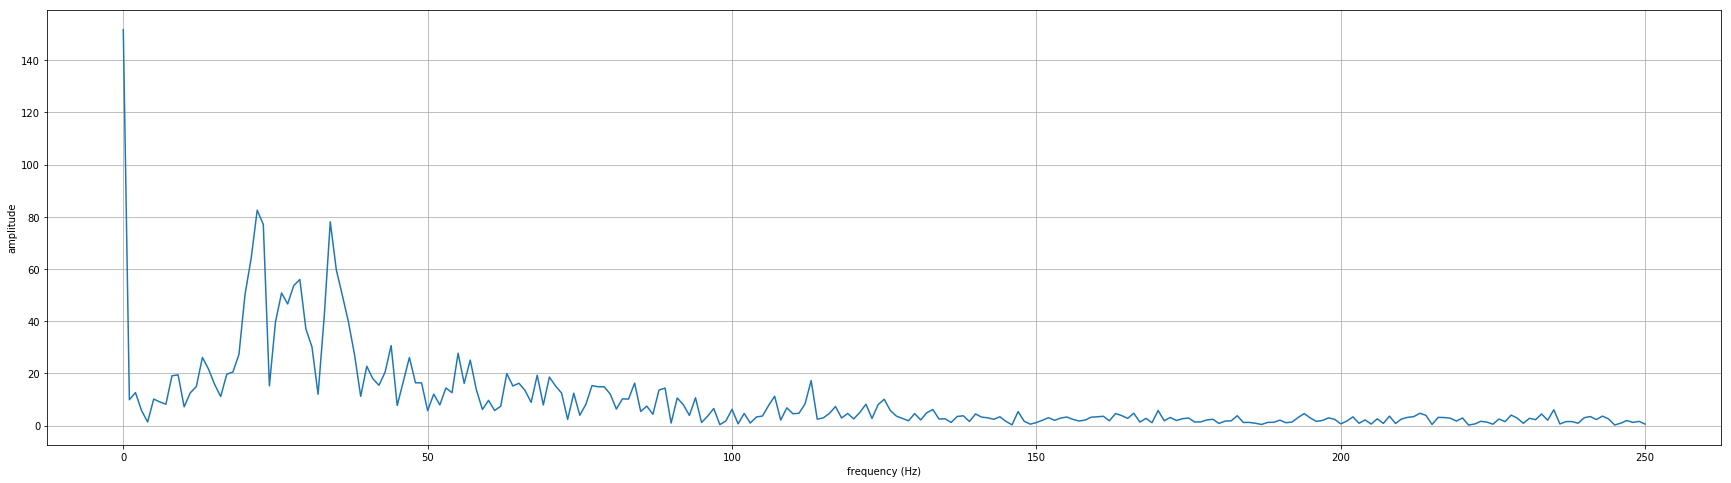

In [33]:
# apply fft transform to scaled data
reduced_data_fft = np.fft.rfft(reduced_data)
reduced_data_fft = np.abs(reduced_data_fft)
# show a feature vector, fft transform
plt.figure(figsize=(30,8))
plt.plot(reduced_data_fft[100])
plt.xlabel('frequency (Hz)')
plt.ylabel('amplitude')
plt.grid()
plt.show()

## Event-based clustering: K-Means (Euclidean distance)

Sum of distances of events to their closest cluster center: 1064679902.8980596


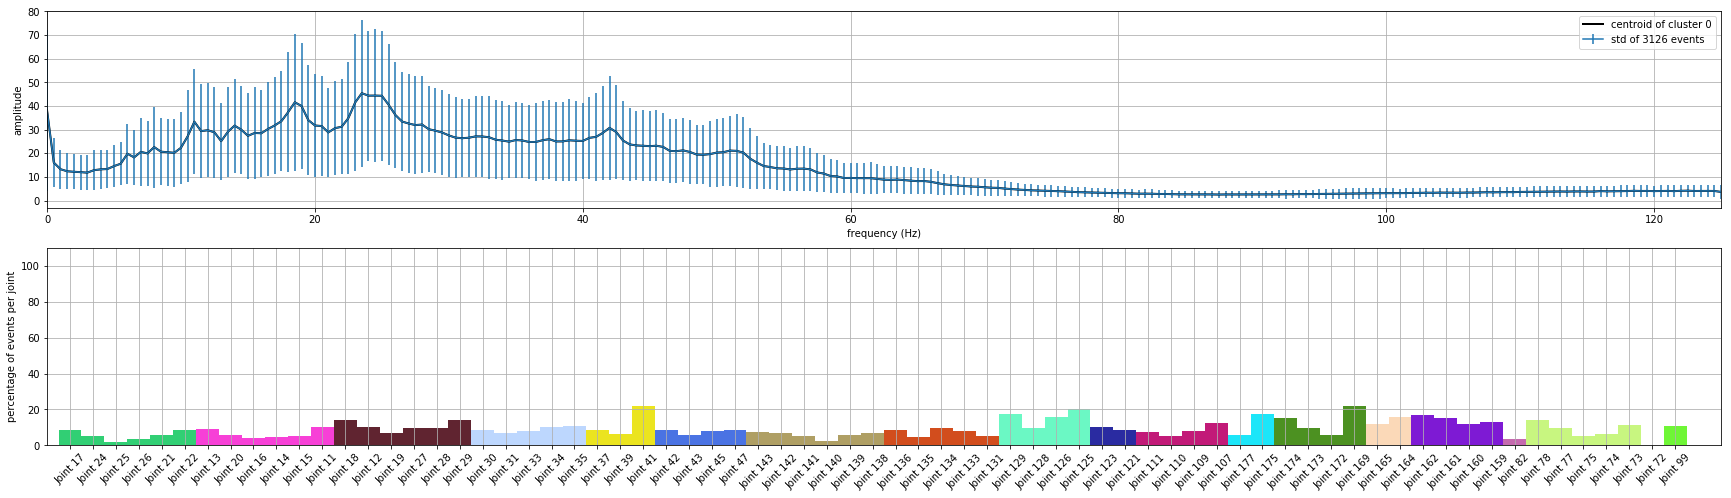

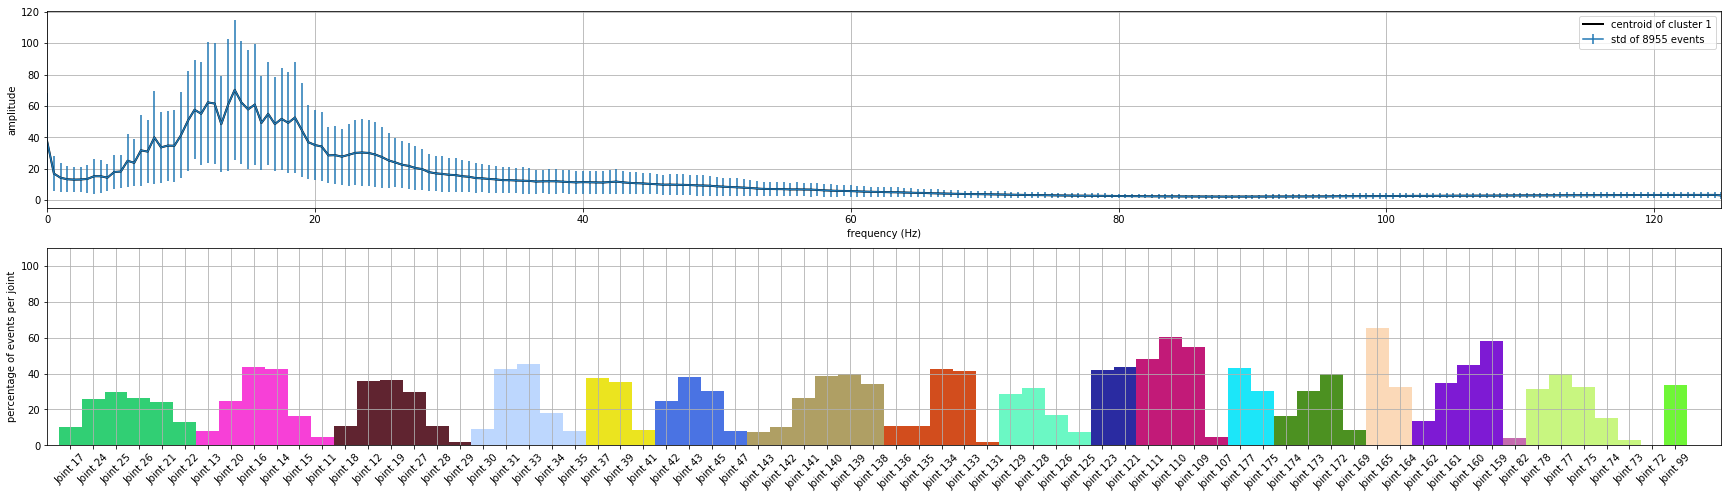

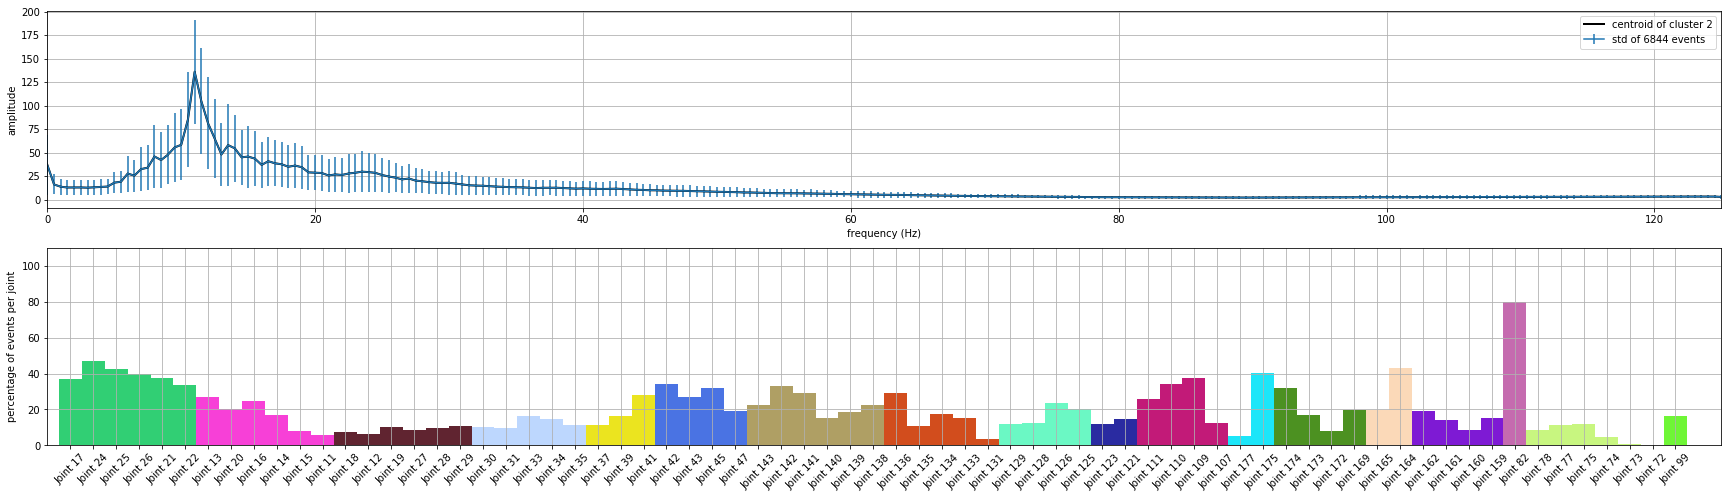

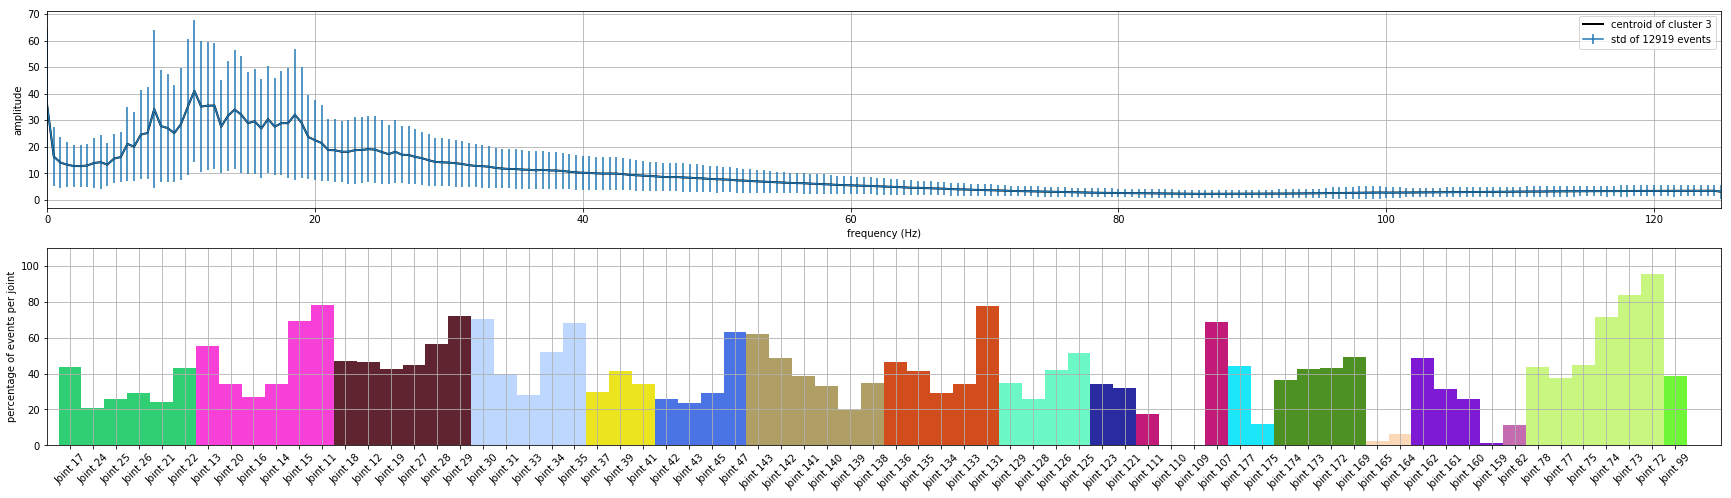

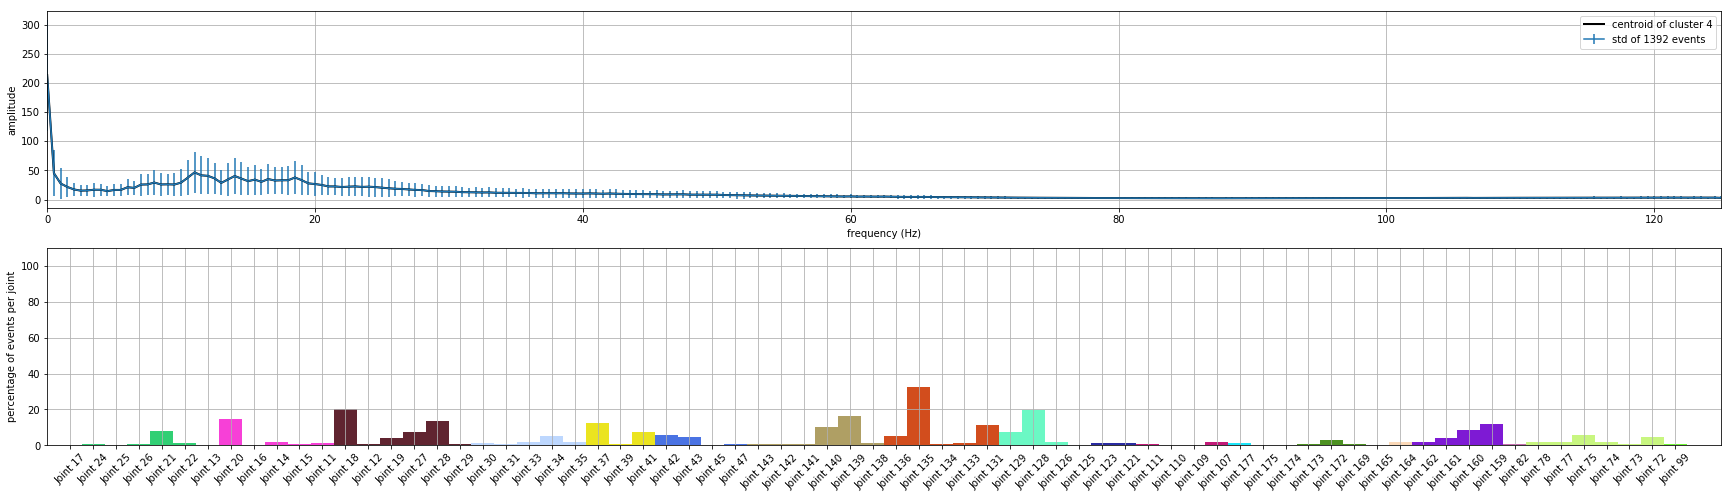

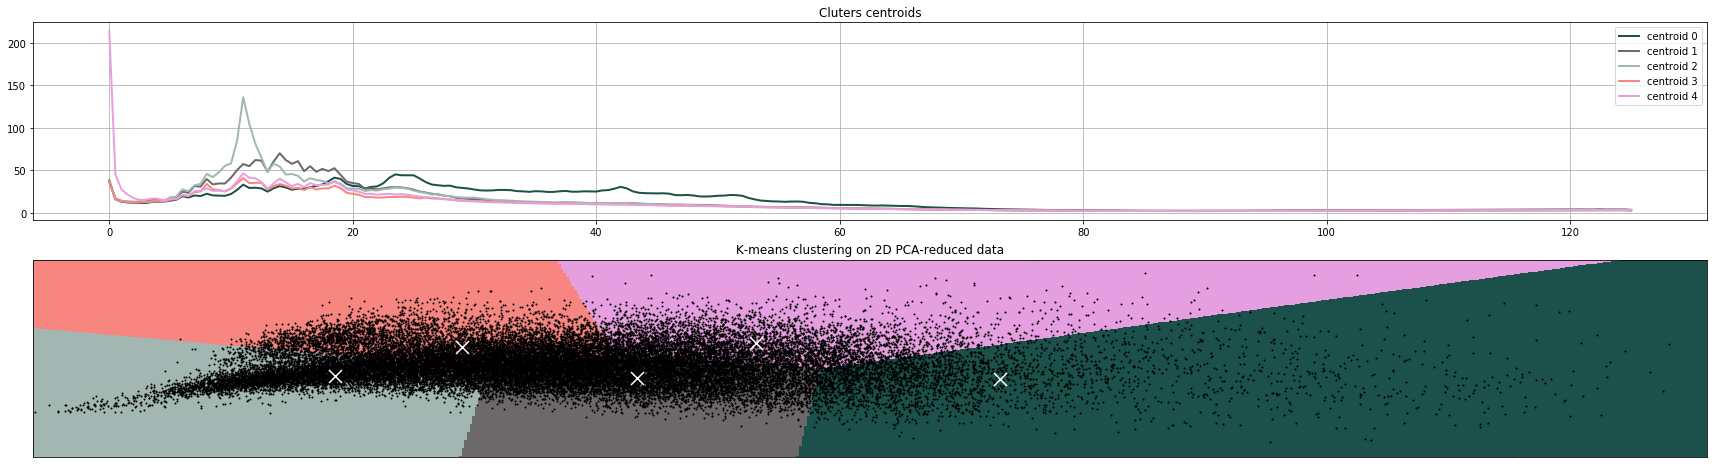

In [34]:
from sklearn.cluster import KMeans
'''
sklearn based KMeans method.
    Inputs:
        - data: training data set containing the events to be processed (matrix [m,n])            
        - n_clusters: number of clusters to be used
    Outputs: (Z, centroids, kmeans) array containing to which formed cluster every event in the training data set belongs to (array [m]), the centroids or mean values (matrix [m, n_clusters]) and the resulting kmeans object
'''
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=20)
kmeans.fit(reduced_data_fft)
Z = kmeans.labels_ 
# obtain centroids    
centroids = kmeans.cluster_centers_
inertia = kmeans.inertia_      
print('Sum of distances of events to their closest cluster center: ' + str(inertia))
final_u = Z 
final_centroids = centroids
final_dist = kmeans

'''
Method to show clustering results. 
    Inputs:
        - data: training data set containing the events to be processed (matrix [m,n])            
        - index: the list of events' labels (joints), (array [m])
        - samples_distribution: the labels distribution, one row per set of labels that will have the same color in the graph
        - centroids: the centroids (matrix [m, n_clusters])
        - Z: array containing to which formed cluster every event in the training data set belongs to (array [m])
        - njoints: 6 or 71
    Outputs: each cluster is represented by two graphs, above the centroid and the std of the events grouped in the cluster and below the events distribution
'''
draw_clustering_results(reduced_data_fft,reduced_index,joints_dist,final_centroids,final_u,njoints=71)


## Joint-based clustering: map of pairwise distances among joints representatives

array([[  0.        ,  80.15981189,  98.92107883, ..., 108.70959303,
        142.84563963,  81.01171869],
       [ 80.15981189,   0.        ,  38.27017382, ..., 163.74577184,
        201.80478394, 116.26392813],
       [ 98.92107883,  38.27017382,   0.        , ..., 170.87860363,
        205.32558182, 131.83318362],
       ...,
       [108.70959303, 163.74577184, 170.87860363, ...,   0.        ,
         54.86389181, 105.55403491],
       [142.84563963, 201.80478394, 205.32558182, ...,  54.86389181,
          0.        , 144.47768645],
       [ 81.01171869, 116.26392813, 131.83318362, ..., 105.55403491,
        144.47768645,   0.        ]])

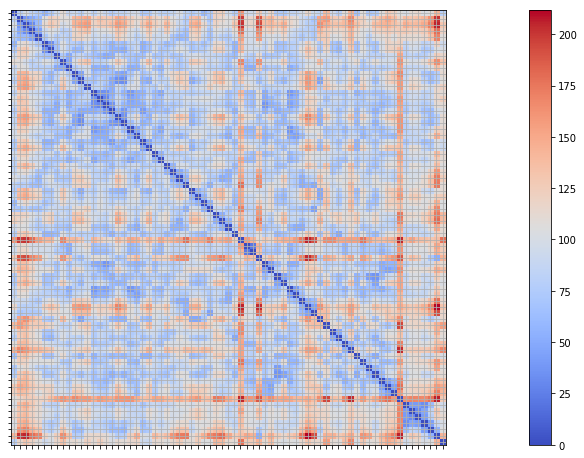

In [35]:
'''
Method that calculates the means of the data related to each label (joints representatives).
    Inputs:
        - data: training data set (matrix [m,n])            
        - labels: array that contains the list of data labels, or data joints (array [m])
        - samples_distribution: the labels distribution, one row per set of labels that will have the same color in the graph
    Outputs: (means, joints) the calculated joints data means (matrix [k,n], k=number of different labels or joints) and joints the list of different joints (array [k])
'''    
means, joints = calculate_joints_means(reduced_data_fft, reduced_index, joints_dist)

'''
Method that creates a map of pairwise distances.
    Inputs:
        - centroids: joint representatives (matrix [m,n])            
        - labels: centroids' labels (array [m])        
        - weights: weighting of centroids (array [m]) 
        - distance: distance metric to be used: Euclidean, Manhattan, Correlation, Minkowski, Minkowski_pthPower, Chebyshev
        - p: pthPower used by Minkowski distance
    Output: (global_matrix) the resulting map of pairwise distances (matrix [m,m])
''' 
draw_matrix_of_distances(means, joints, njoints=6, weights=None, distance='Euclidean', p=0.1)


## Conclusions

- Experimental results showed a good accuracy when accomplishing novelty and damage detection tasks.
- The similarities found among joints located in similar positions of different bridges zones regarding the semi-supervised experiment with 71 joints, demonstrated a feasible location-based classification. Additionally, a faulty sensor and a repaired joint were detected.
- Proposed approach must be adapted to provide a real-time health score of the structure based on distances to models obtained. 
- In order to improve detection capabilities, further experiments must be conducted focusing on vehicle classification based on vibration monitoring.